In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import time
import pytz
from sqlalchemy import create_engine
from oauth2client.client import GoogleCredentials
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
import gspread


zone_mtl = pytz.timezone('America/Montreal')
date_mtl = datetime.now(zone_mtl)
date_mtl
gs_row=1
gs_col=1



gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1C5CKkVvInTiP9XRtuSjjgvSDu-a7RNgwhNQtjAYrWXI/edit#gid=0')
worksheet = wb.add_worksheet(title='LOG-'+str(date_mtl), rows="100", cols="20")


drive.mount('/gdrive') # you may have to authentificate , follow the process of the browser window
#change this
# file_path = '/gdrive/MyDrive/lhl/Mid_Term/flights_2019.csv'
training_file_path ='/gdrive/MyDrive/lhl/Mid_Term/flights_18-19_OCT_NOV_DEC_RIGHT_BEFORE_TRAINING.csv'
test_file_path = '/gdrive/MyDrive/lhl/Mid_Term/flights_test_final_df.csv'
# df = pd.read_csv(file_path,header=0,skiprows=range(1,6000000),nrows=3000000)
df = pd.read_csv(training_file_path,index_col=0)#
df_test = pd.read_csv(test_file_path,index_col=0)#


Mounted at /gdrive


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
filter_forDF_withDelay=['destPrecipMM','origPrecipMM','dayofweek_num','origVisibility','destVisibility','origAvgTempC','destAvgTempC','dest_airport_id','origin_airport_id','tail_num','distance',"crs_dep_time",'arr_delay']
df_test=df_test[['destPrecipMM','origPrecipMM','dayofweek_num','origVisibility','destVisibility','origAvgTempC','destAvgTempC','dest_airport_id','origin_airport_id','tail_num','distance',"crs_dep_time"]]

In [2]:
df=df[filter_forDF_withDelay]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587145 entries, 0 to 2587144
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   destPrecipMM       float64
 1   origPrecipMM       float64
 2   dayofweek_num      int64  
 3   origVisibility     int64  
 4   destVisibility     int64  
 5   origAvgTempC       int64  
 6   destAvgTempC       int64  
 7   dest_airport_id    int64  
 8   origin_airport_id  int64  
 9   tail_num           int64  
 10  distance           int64  
 11  crs_dep_time       int64  
 12  arr_delay          float64
dtypes: float64(3), int64(10)
memory usage: 276.3 MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194628 entries, 0 to 194627
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   destPrecipMM       194628 non-null  float64
 1   origPrecipMM       194628 non-null  float64
 2   dayofweek_num      194628 non-null  int64  
 3   origVisibility     194628 non-null  int64  
 4   destVisibility     194628 non-null  int64  
 5   origAvgTempC       194628 non-null  int64  
 6   destAvgTempC       194628 non-null  int64  
 7   dest_airport_id    194628 non-null  int64  
 8   origin_airport_id  194628 non-null  int64  
 9   tail_num           194628 non-null  int64  
 10  distance           194628 non-null  int64  
 11  crs_dep_time       194628 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 19.3 MB


# correlation

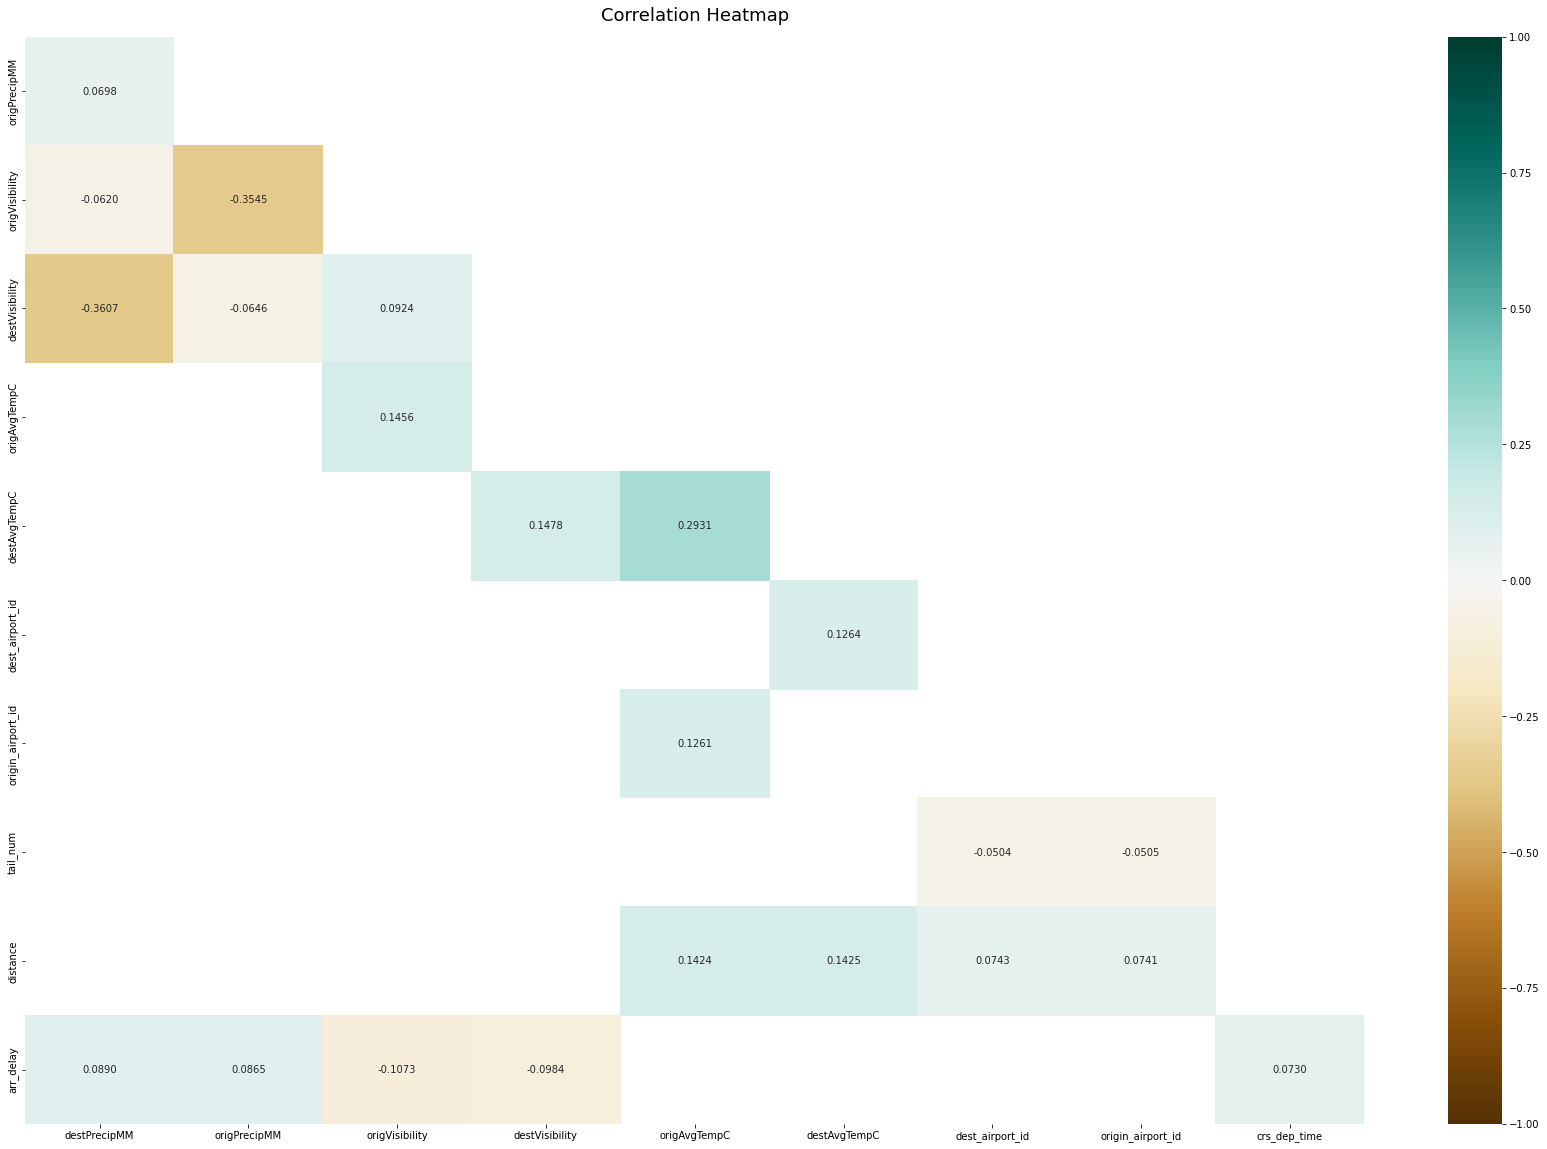

In [5]:
code_block_name = "Correlation HeatMap "
dateTimeObj = datetime.now()
worksheet.update_cell(gs_row,gs_col,code_block_name)
worksheet.update_cell(gs_row,gs_col+1,'Started')
worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#dfFinal = df[['origwindspeedKmph','dayofweek_num','destwindspeedKmph','destPrecipMM','origPrecipMM','origVisibility','destVisibility','destWeatherCode','origWeatherCode','origAvgTempC','destAvgTempC','dest_airport_id','origin_airport_id','tail_num','distance','crs_elapsed_time',"crs_dep_time", "crs_arr_time", "fl_date", "origin", "dest", "arr_delay"]]

corrMatrix = df.corr()

# ndf = df.loc[df.max(axis=1) > 0.30, df.max(axis=0) > 0.30]

# sns.heatmap(ndf)
# plt.show()
# sn.set(rc = {'figure.figsize':(10,6)})
# sn.heatmap(corrMatrix, annot=False)
plt.figure(figsize=(30, 20))
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
cut_off = 0.05  # only show cells with abs(correlation) at least this value
extreme_1 = 0.65  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.95  # show with a third star
mask |= np.abs(corrMatrix) < cut_off
corrMatrix = corrMatrix[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corrMatrix = corrMatrix.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corrMatrix.to_numpy()]
heatmap = sns.heatmap(corrMatrix, vmin=-1, vmax=1, annot=annot, fmt='', cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

plt.show()

dateTimeObj = datetime.now()
worksheet.update_cell(gs_row,gs_col+3,'Finished')
worksheet.update_cell(gs_row,gs_col+4,str(dateTimeObj))
gs_row += 1


# Distribution


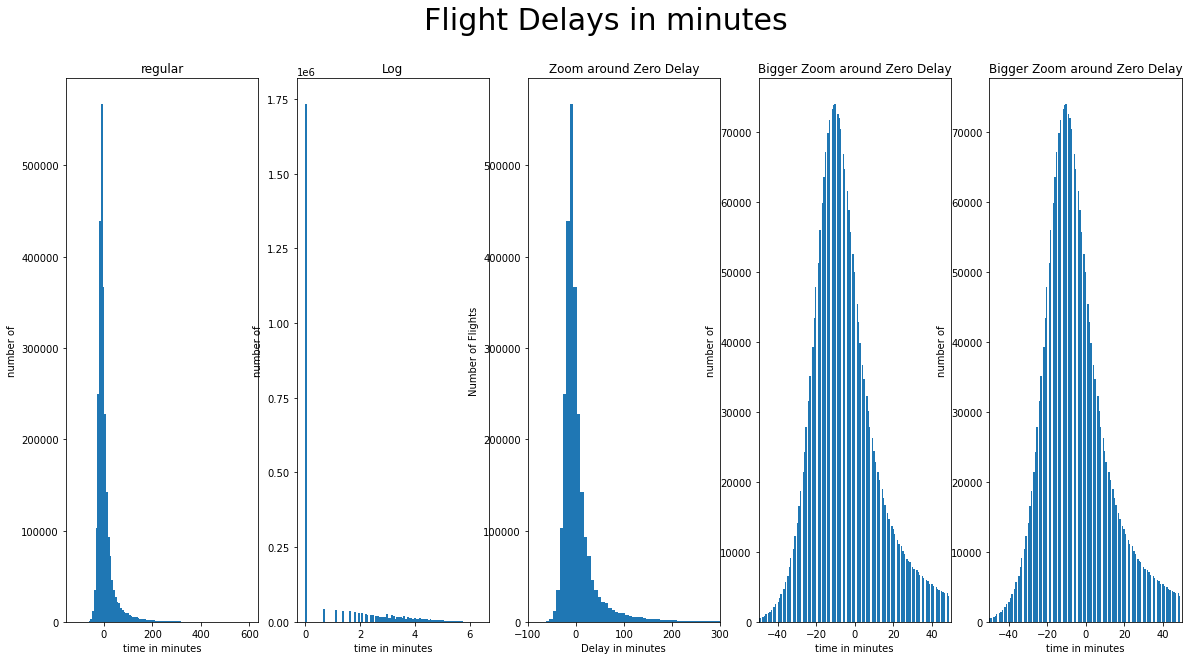

In [7]:
code_block_name = "Distribution Graph "
dateTimeObj = datetime.now()
worksheet.update_cell(gs_row,gs_col,code_block_name)
worksheet.update_cell(gs_row,gs_col+1,'Started')
worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))


#histogram to visualize different distributions. 
#regular, Log, Zoom close to 0, Big zoom close to 0.
fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(20, 10))


ax1.set_xlabel('time in minutes')
ax1.set_ylabel('number of')
ax1.set_title('regular')
ax1.hist(df['arr_delay'], bins=100)



ax2.set_xlabel('time in minutes')
ax2.set_ylabel('number of')
ax2.set_title('Log')
ax2.hist(np.log(df['arr_delay'].clip(1,1000)), bins=100)
# to make the model work better, need normal distribution, so think about logging what will be predicted.
#Then inverse of the log. take the exponent.  np.exp.  ( order of the delay, minutes, hours, days )

#np.exp(log) = arrival delay



ax3.set_xlabel('Delay in minutes')
ax3.set_ylabel('Number of Flights')
ax3.set_title('Zoom around Zero Delay')
ax3.hist(df['arr_delay'], bins=100)
ax3.set_xlim(-100, 300)
fig.suptitle('Flight Delays in minutes', fontsize=30)


ax4.set_xlabel('time in minutes')
ax4.set_ylabel('number of')
ax4.set_title('Bigger Zoom around Zero Delay')
ax4.hist(df['arr_delay'], bins=1000)
ax4.set_xlim(-50, 50)
fig.suptitle('Flight Delays in minutes', fontsize=30)
fig.show


ax5.set_xlabel('time in minutes')
ax5.set_ylabel('number of')
ax5.set_title('Bigger Zoom around Zero Delay')
ax5.hist(df['arr_delay'], bins=1000)
ax5.set_xlim(-50, 50)
fig.suptitle('Flight Delays in minutes', fontsize=30)
fig.show



dateTimeObj = datetime.now()
worksheet.update_cell(gs_row,gs_col+3,'Finished')
worksheet.update_cell(gs_row,gs_col+4,str(dateTimeObj))
gs_row += 1


In [8]:


def train_test_split(df,features_list,target,gs_row,worksheet):
    
    
    from sklearn.model_selection import train_test_split# Import train_test_split function
    gs_col =1
    code_block_name = "train_test_split"
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col,code_block_name)
    worksheet.update_cell(gs_row,gs_col+1,'Started')
    worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))

    X=df[features_list]  # Features
    y=df[target]  # Target
    # import statsmodels.api as sm
    # X = sm.add_constant(X)
    # print(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col+3,'Finished')
    worksheet.update_cell(gs_row,gs_col+4,str(dateTimeObj))
    

    return X_train, X_test, y_train, y_test

def train_model(X_train,y_train,gs_row,worksheet):
   
    gs_col =1
    code_block_name = "train_model sm.OLS(y_train,X_train)"
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col,code_block_name)
    worksheet.update_cell(gs_row,gs_col+1,'Started')
    worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))
   
    
    import statsmodels.api as sm
    print("lin_reg = sm.OLS(X_train,y_train)")
    lin_reg = sm.OLS(y_train.astype(float),X_train.astype(float)) #OLS is the most popular.
    print("model = lin_reg.fit()")
    model = lin_reg.fit()
    print("print_model = model.summary()")
    print_model = model.summary()
    print(print_model)
   
   
    from sklearn.linear_model import LinearRegression
   
    gs_col =1
    code_block_name = "train_model regressor = LinearRegression()"
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col,code_block_name)
    worksheet.update_cell(gs_row,gs_col+1,'Started')
    worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    print("regressor.coef_")
    print(regressor.coef_)
    print(regressor.score(X_train,y_train))
    
    gs_col =1
    code_block_name = "train_model  = RandomForestRegressor()"
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col,code_block_name)
    worksheet.update_cell(gs_row,gs_col+1,'Started')
    worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))


    from sklearn.ensemble import RandomForestRegressor

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col+3,'Finished')
    worksheet.update_cell(gs_row,gs_col+4,str(dateTimeObj))
 

    return model


def predict_results(model,X_train,gs_row,worksheet):
    gs_col =1
    code_block_name = "predict_results"
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col,code_block_name)
    worksheet.update_cell(gs_row,gs_col+1,'Started')
    worksheet.update_cell(gs_row,gs_col+2,str(dateTimeObj))
    
    y_pred=model.predict(X_train)
    
    dateTimeObj = datetime.now()
    worksheet.update_cell(gs_row,gs_col+3,'Finished')
    worksheet.update_cell(gs_row,gs_col+4,str(dateTimeObj))
    

    return y_pred

def score_this(model,y_train,y_pred,features_list,gs_row,worksheet):
    

    gs_col =1
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn.metrics import r2_score
    # Model Accuracy, how often is the classifier correct?
    ModelAccuracy =("Accuracy:",r2_score(y_train, y_pred))

    #Adj_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)
 
    import time
    import numpy as np
    from sklearn import metrics
   
    Mean_Absolute_Error = metrics.mean_absolute_error(y_train, y_pred)  
    Mean_Squared_Error = metrics.mean_squared_error(y_train, y_pred)  
    Root_Mean_Squared_Error = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
    
    print("Mean_Absolute_Error")
    print(Mean_Absolute_Error)
    print("Mean_Squared_Error")
    print(Mean_Absolute_Error)
    print("Root_Mean_Squared_Error")
    print(Root_Mean_Squared_Error)

    worksheet.update_cell(gs_row,gs_col,str(ModelAccuracy))
    worksheet.update_cell(gs_row+1,gs_col,str(Mean_Absolute_Error))
    worksheet.update_cell(gs_row+2,gs_col,str(Mean_Squared_Error))
    worksheet.update_cell(gs_row+3,gs_col,str(Root_Mean_Squared_Error))

    worksheet.update_cell(gs_row+4,gs_col,str(len(df)))
    worksheet.update_cell(gs_row+5,gs_col,str(list(features_list)))
    worksheet.update_cell(gs_row+6,gs_col,str(model.get_params()))
    
    # Evaluating the Algorithm


    start_time = time.time()
    importances = model.feature_importances_
    std = np.std([
        tree.feature_importances_ for tree in model.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute the importances: "
        f"{elapsed_time:.3f} seconds")
    import pandas as pd
    # print("features_list.insert(0, 'const')")
    # features_list.insert(0, 'const')  
    print("NEXT LINE IS forest_importances = pd.Series(importances, index=features_list)")
    print(" this number of features " + str(len(features_list)))
    forest_importances = pd.Series(importances, index=features_list)
    # print("features_list.pop(0)")
    # features_list.pop(0)  
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()
    from sklearn import metrics
    #Simple calculation of Adj. R2

    from datetime import datetime
    
    return ModelAccuracy,Mean_Absolute_Error,Mean_Squared_Error,Root_Mean_Squared_Error

# def filter_this(df,arr_delay_cutoff,gs_row,worksheet):
#     cancelled_filter = (
#     (df['cancelled'] !=0) | 
#     (df['diverted'] !=0 ) | 
#     (df['arr_delay'] >arr_delay_cutoff )
#     )
#     df.drop(df[cancelled_filter].index,inplace=True)

#     return df

In [9]:
dateTimeObj = datetime.now()
import matplotlib.pyplot as plt
import copy



filter_forDF_withDelay.remove('arr_delay')
features_list_o=filter_forDF_withDelay
# features_list_o=['dest_airport_id','origin_airport_id','c_crs_arr_hour','c_crs_dep_hour','dayofweek_num','haul','origwindspeedKmph','destwindspeedKmph','destPrecipMM','origPrecipMM','origVisibility','destVisibility','destWeatherCode','origWeatherCode','origAvgTempC','tail_num']
#features_list_o=(['c_crs_arr_hour','c_crs_dep_hour','origwindspeedKmph'])#,'destwindspeedKmph','destPrecipMM','origPrecipMM','origVisibility','destVisibility','dayofweek_num','destWeatherCode','origWeatherCode','tail_num','month'])

target=['arr_delay']

arr_delay_cutoff_list=150 # The loop will loop thru the different delay types.
months_list=[12]

wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1D6jakWCOJjWmntTMr8erIS8zCYGP_WYNPOjRWRgHLCQ/edit#gid=0')

#check ça df[~df.country.isin(countries_to_keep)]
# df_filter = (
# df['month']!=12 #enter the month you want to keep ( applies to both years )
# )
# df.drop(df[df_filter].index,inplace=True)




zone_mtl = pytz.timezone('America/Montreal')
date_mtl = datetime.now(zone_mtl)

gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1D6jakWCOJjWmntTMr8erIS8zCYGP_WYNPOjRWRgHLCQ/edit#gid=0')
tabName = 'Jo-Training-'# Change the name so we can figure out what is what. 
worksheet = wb.add_worksheet(title=tabName+str(arr_delay_cutoff_list)+" TS "+str(date_mtl), rows="1000", cols="20")


gs_row = 1 
gs_col = 1 
print(arr_delay_cutoff_list)

features_list = copy.deepcopy(features_list_o)

# cancelled_filter = (
# # (df['cancelled'] !=0) | 
# # (df['diverted'] !=0) | 
# # (df['arr_delay'] >arr_delay_cutoff_list)
# )
# df.drop(df[cancelled_filter].index,inplace=True)
# df = filter_this(df,arr_delay_cutoff_list[i],gs_row,worksheet)

dflen=len(df)

worksheet.update_cell(gs_row,gs_col,
                        'Delay >' + str(arr_delay_cutoff_list))
gs_row += 1  
worksheet.update_cell(gs_row,gs_col,
                        'Month = ' +str(months_list))
gs_row += 1  
worksheet.update_cell(gs_row,gs_col,
                        'DF number of rows ' + str(dflen))
gs_row += 1 

             


wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1D6jakWCOJjWmntTMr8erIS8zCYGP_WYNPOjRWRgHLCQ/edit#gid=0')
gs_row += 1  
worksheet.update_cell(gs_row,gs_col,
                    'Number of features ' + str(len(features_list)))
gs_row += 1  
gc = gspread.authorize(GoogleCredentials.get_application_default())
X_train, X_test, y_train, y_test = train_test_split(df,features_list,target,gs_row,worksheet)
gs_row += 1 
model = train_model(X_train,y_train,gs_row,worksheet)
gs_row += 1 
y_pred = predict_results(model,df_test,gs_row,worksheet)


save_to = '/gdrive/MyDrive/lhl/Mid_Term/y_pred.csv'
df.to_csv(save_to)

import pickle
model_save_name='Testing Model.sav'
with open(f"/gdrive/MyDrive/lhl/Mid_Term/{model_save_name}", 'wb') as f:
    pickle.dump(model, f)
    
gs_row += 1 
ModelAccuracy = score_this(model,y_train,y_pred,features_list,gs_row,worksheet)
gs_row += 8
    

import pickle
model_save_name='Testing Model.sav'
with open(f"/gdrive/MyDrive/lhl/Mid_Term/{model_save_name}", 'wb') as f:
    pickle.dump(model, f)





150


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


lin_reg = sm.OLS(X_train,y_train)
model = lin_reg.fit()
print_model = model.summary()
                                 OLS Regression Results                                
Dep. Variable:              arr_delay   R-squared (uncentered):                   0.036
Model:                            OLS   Adj. R-squared (uncentered):              0.036
Method:                 Least Squares   F-statistic:                              5687.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):                        0.00
Time:                        14:35:06   Log-Likelihood:                     -9.2097e+06
No. Observations:             1811001   AIC:                                  1.842e+07
Df Residuals:                 1810989   BIC:                                  1.842e+07
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                        coef    st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


NameError: ignored

# last minute changes


In [10]:

save_to = '/gdrive/MyDrive/lhl/Mid_Term/y_pred.csv'
df.to_csv(save_to)

In [14]:
df_test['predicted_delay']=y_pred

In [16]:

save_to = '/gdrive/MyDrive/lhl/Mid_Term/Abir_Jonathan_Flight_Delay_Submission.csv'
df_test.to_csv(save_to)

In [17]:

import pickle
model_save_name='Jo Testing Model.sav'
with open(f"/gdrive/MyDrive/lhl/Mid_Term/{model_save_name}", 'wb') as f:
    pickle.dump(model, f)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811001 entries, 2124370 to 1634394
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   destPrecipMM       float64
 1   origPrecipMM       float64
 2   dayofweek_num      int64  
 3   origVisibility     int64  
 4   destVisibility     int64  
 5   origAvgTempC       int64  
 6   destAvgTempC       int64  
 7   dest_airport_id    int64  
 8   origin_airport_id  int64  
 9   tail_num           int64  
 10  distance           int64  
 11  crs_dep_time       int64  
dtypes: float64(2), int64(10)
memory usage: 179.6 MB


In [18]:

test_file_path = '/gdrive/MyDrive/lhl/Mid_Term/flights_test_final_df.csv'
# df = pd.read_csv(file_path,header=0,skiprows=range(1,6000000),nrows=3000000)

df_test2 = pd.read_csv(test_file_path,index_col=0)#

In [20]:
df_test2['predicted_delay']=y_pred

In [22]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194628 entries, 0 to 194627
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   destPrecipMM       194628 non-null  float64
 1   origPrecipMM       194628 non-null  float64
 2   origVisibility     194628 non-null  int64  
 3   destVisibility     194628 non-null  int64  
 4   destWeatherCode    194628 non-null  int64  
 5   origWeatherCode    194628 non-null  int64  
 6   origAvgTempC       194628 non-null  int64  
 7   destAvgTempC       194628 non-null  int64  
 8   dest_airport_id    194628 non-null  int64  
 9   origin_airport_id  194628 non-null  int64  
 10  tail_num           194628 non-null  int64  
 11  distance           194628 non-null  int64  
 12  crs_elapsed_time   194628 non-null  int64  
 13  crs_dep_time       194628 non-null  int64  
 14  crs_arr_time       194628 non-null  int64  
 15  fl_date            194628 non-null  object 
 16  or

In [24]:
df_test2=df_test2[['fl_date','year', 'month', 'day', 'dayofweek_num', 'origin_airport_id','origin','dest_airport_id','dest',
       'tail_num','op_unique_carrier', 'destPrecipMM', 'origPrecipMM', 'origVisibility', 'destVisibility',
       'destWeatherCode', 'origWeatherCode', 'origAvgTempC', 'destAvgTempC',
         'distance',
       'crs_elapsed_time', 'crs_dep_time', 'crs_arr_time',   
       'predicted_delay']]

In [26]:
df_test2['fl_date']= pd.to_datetime(df_test2['fl_date'])


In [29]:
datefilter = df_test2['fl_date'] <= '2020-01-07'
df_test2 = df_test2[datefilter]

In [30]:
df_test2

,fl_date,year,month,day,dayofweek_num,origin_airport_id,origin,dest_airport_id,dest,tail_num,op_unique_carrier,destPrecipMM,origPrecipMM,origVisibility,destVisibility,destWeatherCode,origWeatherCode,origAvgTempC,destAvgTempC,distance,crs_elapsed_time,crs_dep_time,crs_arr_time,predicted_delay
0,2020-01-01,2020,1,1,2,13891,246,14771,312,5322,4805,0.0,0.0,10,10,116,116,15,13,363,95,1810,1945,4.04
1,2020-01-01,2020,1,1,2,13891,246,14771,312,2165,1297,0.0,0.0,10,10,116,116,15,13,363,90,1150,1320,24.03
2,2020-01-01,2020,1,1,2,13891,246,14831,318,3867,3187,0.0,0.0,10,7,143,116,15,12,333,70,2020,2130,11.55
3,2020-01-01,2020,1,1,2,13891,246,14831,318,2507,1677,0.0,0.0,10,10,122,116,15,12,333,75,1340,1455,17.90
4,2020-01-01,2020,1,1,2,13891,246,14831,318,5443,4939,0.0,0.0,10,10,116,116,15,12,333,80,915,1035,-6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150618,2020-01-07,2020,1,7,1,11433,99,12478,176,2741,1937,0.0,0.0,10,7,332,122,2,3,509,117,1755,1952,2.45
150619,2020-01-07,2020,1,7,1,11996,141,12953,196,5022,4472,0.0,0.3,10,10,122,296,8,3,610,119,600,759,41.60
150620,2020-01-07,2020,1,7,1,10397,20,15919,358,5216,4687,0.0,0.0,10,10,113,113,10,4,589,121,1715,1816,-7.49
150621,2020-01-07,2020,1,7,1,15919,358,10397,20,5216,4687,0.0,0.0,10,10,113,113,4,10,589,114,1851,2145,2.30


In [ ]:
df_test2['Date']= pd.to_datetime(df_test2['Date'])

In [31]:
save_to = '/gdrive/MyDrive/lhl/Mid_Term/Abir_Jonathan_Flight_Delay_Submission_with_fl_dates_Final_v1.csv'
df_test2.to_csv(save_to)